<a href="https://colab.research.google.com/github/skywalker0803r/c620/blob/main/notebook/C670.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import joblib
from google.colab import drive
drive.mount('/content/drive')
#!pip install autorch
import autorch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
c = joblib.load('/content/drive/MyDrive/台塑輕油案子/data/c620/col_names/c670_col_names.pkl')
c.keys()

dict_keys(['xTray43', 'xTray54', 'combined', 'yRefluxRate', 'yControl', 'yHeatDuty', 'distillate_x', 'bottoms_x', 'distillate_sf', 'bottoms_sf', 'density'])

In [21]:
c670_df = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_train.csv',index_col=0).dropna(axis=0).astype('float32')
c670_df.head(3)

,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Hydrogen_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Propane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Butane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Benzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Cyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Heptane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Water_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Methylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Toluene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Octane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclopentane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_p-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_m-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_o-Xylene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Nonane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_i-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylcyclohexane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Propylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-3-ethylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,3,5-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-2-ethylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,4-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_tert-Butylcyclohexane_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3-Trimethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Indane_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1-Methyl-4-n-propylbenzene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2-Diethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_5-Ethyl-m-xylene_wt%,"Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,4-Diethylbenzene_wt%","Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_1,2,3,5-Tetramethylbenzene_wt%",Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Pentylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_n-Hexylbenzene_wt%,Combined Feed to Toluene Column C670 @ Tray 43_Detailed Composition_Nitrogen_wt%,...,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Methane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Ethane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_Propane_Fraction,Toluene Column C670 Split Factors Calculation_Split Factor for Individual Component to Toluene Column C670 Bottoms_n-Bu

# 加入BF特徵

In [22]:
c670_mb = pd.read_csv('/content/drive/MyDrive/台塑輕油案子/data/c620/cleaned/c670_mbcheck.csv',index_col=0)
c670_mb.head(3)

,Combined Feed to Toluene Column C670 @ Tray 43_Flow Rate_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Feed Properties \n@ Tray 43_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Feed Properties \n@ Tray 54_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Distillate Production Rate and Composition_Mass Flow Rate_ton/hr,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Mass Flow Rate_ton/hr
001-001,18.150902,18.150902,124.981539,72.607789,70.524656
001-002,18.151391,18.151391,124.981555,72.608289,70.524656
001-003,18.151730,18.151730,124.981555,72.608625,70.524656


In [23]:
Tray_43_mfr = c670_mb.iloc[:,[1]]
Tray_54_mfr = c670_mb.iloc[:,[2]]
c670_df = c670_df.join(Tray_43_mfr).join(Tray_54_mfr)

# 欄位定義

In [24]:
x_col = c['combined'] + Tray_43_mfr.columns.tolist() + Tray_54_mfr.columns.tolist()
s_col = c['distillate_sf']+c['bottoms_sf']
wt_col = c['distillate_x']+c['bottoms_x']
op_col = c['density']+c['yRefluxRate']+c['yHeatDuty']+c['yControl']
y_col = s_col + op_col
len(x_col),len(y_col)

(43, 89)

In [25]:
n_idx = [[i,i+41] for i in range(41)]
for idx in n_idx:
  assert np.allclose(c670_df[y_col].iloc[:,idx].sum(axis=1).mean(),1.0)

# train

  0%|          | 1/300 [00:00<03:13,  1.55it/s]

epoch:0 train_loss:0.0067 valid_loss:0.0025


 17%|█▋        | 51/300 [00:43<03:43,  1.11it/s]

epoch:50 train_loss:0.0018 valid_loss:0.0018


 34%|███▎      | 101/300 [01:27<02:52,  1.15it/s]

epoch:100 train_loss:0.0016 valid_loss:0.0017


 50%|█████     | 151/300 [02:12<02:16,  1.09it/s]

epoch:150 train_loss:0.0016 valid_loss:0.0016


 67%|██████▋   | 201/300 [03:01<01:42,  1.04s/it]

epoch:200 train_loss:0.0015 valid_loss:0.0016


 84%|████████▎ | 251/300 [03:56<00:55,  1.13s/it]

epoch:250 train_loss:0.0015 valid_loss:0.0016


100%|██████████| 300/300 [04:56<00:00,  1.01it/s]


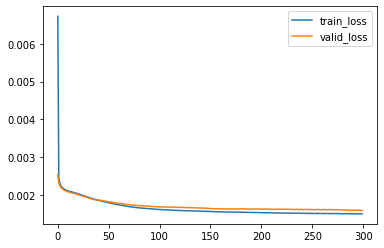

In [26]:
from autorch.utils import PartBulider
c670 = PartBulider(c670_df,x_col,y_col,normalize_idx_list=n_idx)
c670.train()

In [28]:
res = c670.test(e=0.02).loc[op_col,:]
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
Density_Distillate Production Rate and Composition,0.998073,1.54845e-12,0.000113056
Density_Bottoms Production Rate and Composition,0.999499,9.2217e-11,0.000861746
Toluene Column C670 Operation_Yield \nSummary_Reflux Rate_m3/hr,0.998086,1.19332,0.329223
Toluene Column C670 Operation_Heat Duty_Condenser Heat Duty_Mkcal/hr,0.998155,0.0164666,0.337225
Toluene Column C670 Operation_Heat Duty_Reboiler Heat Duty_Mkcal/hr,0.998157,0.0156652,0.330811
Toluene Column C670 Operation_Column Temp Profile_C670 Tray 24 (Control)_oC,0.996888,0.000186621,0.0055651
Toluene Column C670 Operation_Column Temp Profile_C670 Btm Temp (Control)_oC,0.999255,0.0020546,0.015616
AVG,0.998302,0.175384,0.145631


# wt預測結果 

In [29]:
from autorch.function import sp2wt

x_test = c670.data['X_test']
x41 = x_test[c['combined']].values
sp = c670.predict(x_test).iloc[:,:41*2]
s1,s2 = sp.iloc[:,:41].values,sp.iloc[:,41:41*2].values
w1,w2 = sp2wt(x41,s1),sp2wt(x41,s2)
wt_pred = np.hstack((w1,w2))
wt_pred = pd.DataFrame(wt_pred,index=x_test.index,columns=wt_col)
wt_pred.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [30]:
wt_real = c670_df.loc[x_test.index,wt_col]
wt_real.head(3)

,Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Benzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Cyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Heptane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Water_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Methylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Toluene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Octane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclopentane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_p-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_m-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_o-Xylene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Nonane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_i-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylcyclohexane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Propylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-3-ethylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,3,5-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-2-ethylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,4-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_tert-Butylcyclohexane_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3-Trimethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_Indane_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_1-Methyl-4-n-propylbenzene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2-Diethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_5-Ethyl-m-xylene_wt%,"Toluene Column C670 Operation_Distillate Production Rate and Composition_1,4-Diethylbenzene_wt%","Toluene Column C670 Operation_Distillate Production Rate and Composition_1,2,3,5-Tetramethylbenzene_wt%",Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Pentylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Hexylbenzene_wt%,Toluene Column C670 Operation_Distillate Production Rate and Composition_Nitrogen_wt%,...,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Methane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Ethane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition_Propane_wt%,Toluene Column C670 Operation_Bottoms Production Rate and Composition

In [31]:
res = c670.show_metrics(wt_real,wt_pred,e=0.02).fillna(0)
res

,R2,MSE,MAPE
Toluene Column C670 Operation_Distillate Production Rate and Composition_Hydrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Methane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Ethane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_Propane_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Distillate Production Rate and Composition_n-Butane_wt%,1.000000,0.000000e+00,0.000000
...,...,...,...
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Pentylbenzene_wt%,1.000000,3.292766e-09,0.003437
Toluene Column C670 Operation_Bottoms Production Rate and Composition_n-Hexylbenzene_wt%,1.000000,5.813018e-10,0.003510
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Nitrogen_wt%,1.000000,0.000000e+00,0.000000
Toluene Column C670 Operation_Bottoms Production Rate and Composition_Oxygen_wt%,1.000000,0.000000e+00,0.000000


In [32]:
c670.shrink()

In [33]:
joblib.dump(c670,'/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl')

['/content/drive/MyDrive/台塑輕油案子/data/c620/model/c670.pkl']